In [1]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_DAT import AutoDAT
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.analysis.ROI_draw import ImageDrawToROI

In [2]:
""" Response Density

    Going with approach 3 -- manual selection 

    Approach #1
        1) Select x number of ROIs via Python GUI, in this order:
            First two correspond to L2/3 and L5
            Rest (until exit) correspond to L4 barrels from top
            to bottom, left to right
        2) Create ROI object listing member pixels for each ROI
        3) For each ROI, for each frame's SNR dat, calculate 
            the proportion of pixels with SNR>cutoff (call this
            the response density of that ROI)
        4) Build a list of densities as a function of time for
            each layer, for statistical analysis
            
        OR
        
    Approach #2
        1) Read in corners (barrel and layer) and a file
            denoting the direction of the slice edge
        2) Divide area into three regions: L2/3, L4, L5,
            with L2/3 being closest to slice edge
        3) Divide L4 into 3 barrels.
        
        OR 
        
    Approach #3
        1) Read in list of ROIs (a PhotoZ .dat file):
            First one is L2/3 (L23_ROI.dat)
            Next is L5 (L5_ROI.dat)
            The rest are L4 barrels (L4_barrel_<i>.dat) for <i>=0,1,2... top to bottom, left to right
        2) For each ROI, for each frame's SNR dat, calculate 
            the proportion of pixels with SNR>cutoff (call this
            the response density of that ROI)
        3) Build a list of densities as a function of time for
            each layer, for statistical analysis
        
"""
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
start_frame = 94
movie_length = 27
snr_cutoff = 5.0

disable_photoZ_interact = False
initialize_photoZ = False
clean_scratch_files = False  # clean up SNR maps
replace_existing_frame_dats = False

In [3]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and not disable_photoZ_interact:
    aPhz.prepare_photoZ()
if not disable_photoZ_interact:
    aPhz.click_normalize_2_array_max()
pa.alert("Please disable trace overlay and maximize PhotoZ before continuing.")

'OK'

02_01_01
2 1
Selecting ROI: layer23_roi
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23/selected_zda//analysis02_01_01/layer23_roi.dat
Wrote layer23_roi file to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23/selected_zda//analysis02_01_01/
Selecting ROI: layer5_roi
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23/selected_zda//analysis02_01_01/layer5_roi.dat
Wrote layer5_roi file to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23/selected_zda//analysis02_01_01/
Selecting ROI: layer4_roi_0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0.

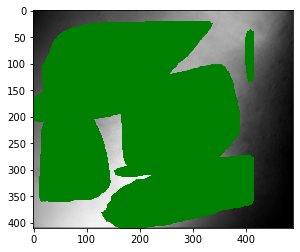

02_01_03
02_02_02
2 2
Selecting ROI: layer23_roi
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23/selected_zda//analysis02_02_02/layer23_roi.dat
Wrote layer23_roi file to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23/selected_zda//analysis02_02_02/
Selecting ROI: layer5_roi
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23/selected_zda//analysis02_02_02/layer5_roi.dat
Wrote layer5_roi file to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/02-28-23/selected_zda//analysis02_02_02/
Selecting ROI: layer4_roi_0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 

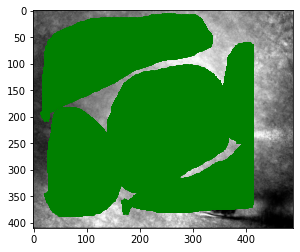

03_01_01
3 1
Selecting ROI: layer23_roi


In [ ]:
img_draw_roi = ImageDrawToROI(data_dir)
roi_filename_prefixes = ['layer23_roi', 'layer5_roi', 'layer4_roi_0', 'layer4_roi_1', 'layer4_roi_2']
which_image_to_annotate = ['f', 'f', 'f', 'f', 'f']
img_draw_roi.draw_ROI(roi_filename_prefixes, which_image_to_annotate)

In [ ]:

for subdir, dirs, files in os.walk(data_dir):
    if 'notUsable' in subdir:
        continue
    if 'mm_hidden' in subdir:
        continue
    if 'converted_zda' in subdir:
        continue

    for zda_file in files:
        if not zda_file.endswith('.zda'):
            continue

        rec_id = zda_file.split('.')[0]
        print(rec_id)
        # movie dir
        movie_dir = subdir + "/responseArea" + rec_id + "/"

        slic, loc, rec = [int(x) for x in rec_id.split("_")]
        print(slic, loc, rec)
        try:
            os.makedirs(movie_dir)
        except Exception as e:
            pass

        if not disable_photoZ_interact:
            aPhz = AutoPhotoZ(data_dir=subdir)


            need_to_open_zda = False
            for frame in range(start_frame, start_frame + movie_length):
                f = aPhz.pad_zeros(slic) + "_" + aPhz.pad_zeros(loc) + "_" + aPhz.pad_zeros(rec) + ".dat"
                f = subdir + "/SNR_" + rec_id + "_frame" + str(frame)+"_" + f
                if not os.path.exists(f):
                    need_to_open_zda = True

            need_to_open_zda = (need_to_open_zda or replace_existing_frame_dats)
            if need_to_open_zda:
                # open the PhotoZ file
                aPhz.select_PhotoZ()

                print("\n\nOpening", zda_file)
                aPhz.open_zda_file(subdir + "/" + zda_file)

                # set measure window width to 1
                aPhz.set_measure_window(None, 1)
            for frame in range(start_frame, start_frame + movie_length):
                f = aPhz.pad_zeros(slic) + "_" + aPhz.pad_zeros(loc) + "_" + aPhz.pad_zeros(rec) + ".dat"
                f = subdir + "/SNR_" + rec_id + "_frame" + str(frame)+"_" + f
                if not os.path.exists(f):
                    aPhz.set_measure_window(frame, None)
                    aPhz.select_array_tab()
                snr_filename = AutoDAT(datadir=subdir,
                        file_prefix="SNR_" + rec_id + "_frame" + str(frame)+"_").save_background(slic, 
                                                                                                 loc, 
                                                                                                 rec,
                                                                                                 overwrite_existing=replace_existing_frame_dats)
                if subdir not in snr_dict:
                    snr_dict[subdir] = {}
                if rec_id not in snr_dict[subdir]:
                    snr_dict[subdir][rec_id] = {}
                if frame not in snr_dict[subdir][rec_id]:
                    snr_dict[subdir][rec_id][frame] = { 'filename': snr_filename }

In [ ]:
for subdir, dirs, files in os.walk(data_dir):
    if 'notUsable' in subdir:
        continue
    if 'mm_hidden' in subdir:
        continue
    if 'converted_zda' in subdir:
        continue
    
    for zda_file in files:
        if not zda_file.endswith('.zda'):
            continue

        rec_id = zda_file.split('.')[0]
        print(rec_id)
        # movie dir
        movie_dir = subdir + "/responseArea" + rec_id + "/"
        
        slic, loc, rec = [int(x) for x in rec_id.split("_")]
        print(slic, loc, rec)
        
        snr_frames = []
        areas_over_time = []
        images = []
        for frame in range(start_frame, start_frame + movie_length):
            snr_filename = snr_dict[subdir][rec_id][frame]['filename']

            snr_frame = np.loadtxt(snr_filename,
                         delimiter='\t',
                         usecols=(1,))
            width = int(np.sqrt(snr_frame.shape[0]))
            snr_frame = snr_frame.reshape((width, width))
            snr_frame = (snr_frame > snr_cutoff)
            area = np.sum(snr_frame)
            snr_frames.append(snr_frame)
            areas_over_time.append(area)
            # print(snr_frame, area)
            plt.clf()
            plt.imshow(snr_frame)
            fn_image = movie_dir + str(frame) + ".png"
            plt.savefig(fn_image)
            images.append(imageio.imread(fn_image))
            
        # plot A(t)
        print(subdir)
        plt.clf()
        plt.plot([i for i in range(start_frame, start_frame + movie_length)], 
                 areas_over_time)
        plt.xlabel("Frame Number")
        plt.ylabel("Signal Area (pixels)")
        plt.title("Responding Area over Time")
        plt.savefig(movie_dir + "area.png")
        plt.show()
        
        # Make boolean signal movie (animated gif)
        created_movie = False
        try:
            imageio.mimsave(movie_dir + 'area_movie.gif', images)
            print("CREATED MOVIE:", rec_id + 'area_movie.gif')
            created_movie = True
            if clean_scratch_files:
                for img_file in img_filenames:
                    os.remove(img_file)
        except Exception as e:
            if not created_movie:
                print("Not creating movie for " + rec_id)
            print(e)
        